In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.utils import resample


In [2]:
os.chdir(r"C:\Users\dsala\Downloads")

In [3]:
base=pd.read_csv('GEIH2018_filtered_data.csv')

In [4]:
base['Log_salario']=np.log(base['y_total_m_ha'])
base['edad^2']=base['age']**2


In [5]:
# Definir las variables independientes y dependiente
X = base[['age', 'edad^2']]
X = sm.add_constant(X)  
y = base['Log_salario']

# corremos el modelo
modelo_edad = sm.OLS(y, X).fit()


In [6]:
print(modelo_edad.summary())

                            OLS Regression Results                            
Dep. Variable:            Log_salario   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     181.1
Date:                Sat, 14 Sep 2024   Prob (F-statistic):           2.75e-78
Time:                        16:47:25   Log-Likelihood:                -15186.
No. Observations:               12826   AIC:                         3.038e+04
Df Residuals:                   12823   BIC:                         3.040e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.4742      0.064    116.285      0.0

calculamos el peak age

In [7]:
betas = modelo_edad.params
beta2 = betas['age']
beta3 = betas['edad^2']


peak_age = -beta2 / (2 * beta3)
print(f'Edad Pico: {peak_age}')



Edad Pico: 42.18042829242302


Bootstrap para obtener el intervalo de confianza del peak age

In [14]:

n_iterations = 5000  
bootstrap_peak_ages = []

for _ in range(n_iterations):
   
    base_resample = resample(base)
    X_resample = base_resample[['age', 'edad^2']]
    X_resample = sm.add_constant(X_resample)
    y_resample = base_resample['Log_salario']

    # Ajustar el modelo de regresión en la submuestra
    model_resample = sm.OLS(y_resample, X_resample).fit()

    # Calcular la edad pico para esta submuestra
    beta2_resample = model_resample.params['age']
    beta3_resample = model_resample.params['edad^2']
    peak_age_resample = -beta2_resample / (2 * beta3_resample)
    
    # Guardar el peak age de la submuestra
    bootstrap_peak_ages.append(peak_age_resample)

# Calcular el intervalo de confianza del 95%
ci_lower = np.percentile(bootstrap_peak_ages, 2.5)
ci_upper = np.percentile(bootstrap_peak_ages, 97.5)
print(f'Intervalo de confianza al 95% de la peak-age: [{ci_lower}, {ci_upper}]')



Intervalo de confianza al 95% de la peak-age: [41.38811038134192, 43.05872197407974]


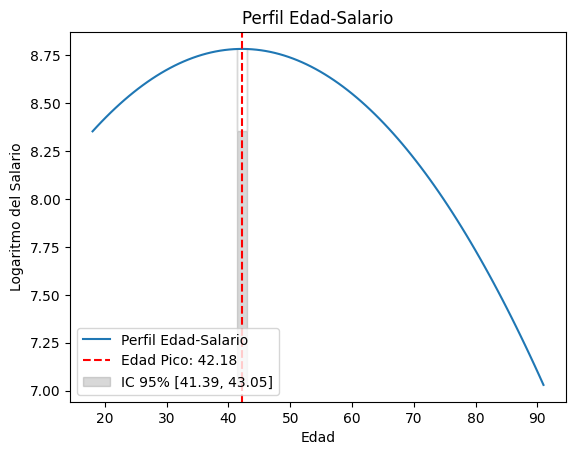

In [10]:
# Graficar el perfil edad-salario
age_range = np.linspace(base['age'].min(), base['age'].max(), 100)
salario_estimado = betas['const'] + betas['age'] * age_range + betas['edad^2'] * age_range**2

plt.plot(age_range, salario_estimado, label='Perfil Edad-Salario')
plt.axvline(x=peak_age, color='red', linestyle='--', label=f'Edad Pico: {peak_age:.2f}')
plt.fill_betweenx(salario_estimado, ci_lower, ci_upper, color='gray', alpha=0.3, label=f'IC 95% [{ci_lower:.2f}, {ci_upper:.2f}]')
plt.xlabel('Edad')
plt.ylabel('Logaritmo del Salario')
plt.title('Perfil Edad-Salario')
plt.legend()
plt.show()


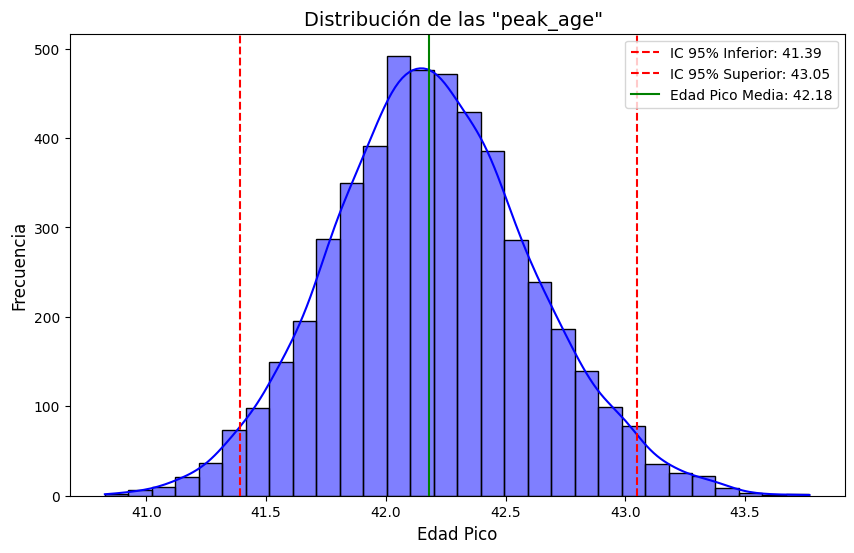

In [12]:


# Graficar la distribución 
plt.figure(figsize=(10, 6))


sns.histplot(bootstrap_peak_ages, kde=True, color='blue', bins=30)

# Añadir el intervalo de confianza
plt.axvline(x=ci_lower, color='red', linestyle='--', label=f'IC 95% Inferior: {ci_lower:.2f}')
plt.axvline(x=ci_upper, color='red', linestyle='--', label=f'IC 95% Superior: {ci_upper:.2f}')
plt.axvline(x=peak_age, color='green', linestyle='-', label=f'Edad Pico Media: {peak_age:.2f}')


plt.title('Distribución de las "peak_age" ', fontsize=14)
plt.xlabel('Edad Pico', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.legend()


plt.show()
